# <center> A/B-тестирование </center>

<b>Описание:</b>

Было проведено А/В-тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. 

<b>Цель:</b> оценка результаты А/В-тестирования.

<b>Техническое задание:</b>
- название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page ,
    - просмотры корзины — product_cart ,
    - покупки — purchase .

<b>Задачи:</b>
1. Загрузка и предобработка данных.
2. Проверка соответствию техническому заданию.
3. Исследовательский анализ данных.
4. Оценка результатов A/B-тестирования.

<b>Описание данных</b>:
1. <b>ab_project_marketing_events.csv</b> — календарь маркетинговых событий:
    - name — название маркетингового события;
    - regions — регионы, в которых будет проводиться рекламная кампания;
    - start_dt — дата начала кампании;
    - finish_dt — дата завершения кампании.
2. <b>final_ab_new_users.csv</b> — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:
    - user_id — идентификатор пользователя;
    - first_date — дата регистрации;
    - region — регион пользователя;
    - device — устройство, с которого происходила регистрация.
3. <b>final_ab_events.csv</b> — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
    - user_id — идентификатор пользователя;
    - event_dt — дата и время события;
    - event_name — тип события;
    - details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
4. <b>final_ab_participants.csv</b> — таблица участников тестов:
    - user_id — идентификатор пользователя;
    - ab_test — название теста;
    - group — группа пользователя.

## Загрузка и предобработка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
    
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

<b> final_ab_events </b>

In [2]:
#загрузка final_ab_events
try:
    final_ab_events = pd.read_csv(r'C:\Users\Евгения\python\Projects\AB-test\final_ab_events.csv')
except:
    print('Ошибка загрузки данных')
final_ab_events.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [3]:
#общая информация, в том числе для оценки пропусков и типов данных
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [4]:
#проверка полных явных дубликатов 
final_ab_events.duplicated().sum()

0

In [5]:
#преобразование типов данных 
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

In [6]:
#добавление столбца с датой события
final_ab_events['event_date'] = final_ab_events['event_dt'].dt.date

Загружена таблица с данными о совершенных события. Всего 440317 строк, дубликатов нет.Был преобразован тип данных на datetime в стобце event_dt. Был добавлен столбце даты события.  

In [7]:
#проверка при каких событиях в деталях нет пропусков
final_ab_events[~final_ab_events['details'].isna()]['event_name'].unique()

array(['purchase'], dtype=object)

In [8]:
#значения в столбце details при событии purchase
final_ab_events[final_ab_events['event_name']=='purchase']['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99])

В столбце details пропусков нет только при событии purchase, т.е. заказ. В этом столбце указывается стоимость покупки.

<b> ab_project_marketing_events </b>

In [9]:
#загрузка ab_project_marketing_events
try:
    ab_project_marketing_events = pd.read_csv(r'C:\Users\Евгения\python\Projects\AB-test\ab_project_marketing_events.csv')
except:
    print('Ошибка загрузки данных')
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [10]:
#общая информация, в том числе для оценки пропусков и типов данных
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [11]:
#проверка полных явных дубликатов 
ab_project_marketing_events.duplicated().sum()

0

In [12]:
#уникальные названия маркетингового события для проверки неявных дубликатов 
ab_project_marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [13]:
#уникальные регионы маркетингового события для проверки неявных дубликатов 
ab_project_marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [14]:
#преобразование типов данных 
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format = '%Y-%m-%d')
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format = '%Y-%m-%d')

Загружена таблица с данными о маркетинговых событиях. Всего 14 строк, дубликатов нет, пропусков нет. Был преобразован тип данных на datetime в стобцах дат начала и окончания маркетингового события.

<b> final_ab_new_users </b>

In [15]:
#загрузка final_ab_new_users
try:
    final_ab_new_users = pd.read_csv(r'C:\Users\Евгения\python\Projects\AB-test\final_ab_new_users.csv')
except:
    print('Ошибка загрузки данных')
final_ab_new_users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [16]:
#общая информация, в том числе для оценки пропусков и типов данных
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [17]:
#проверка полных явных дубликатов 
final_ab_new_users.duplicated().sum()

0

In [18]:
#проверка дубликатов в столбце user_id
final_ab_new_users['user_id'].duplicated().sum()

0

In [19]:
#уникальные регионов пользователя для проверки неявных дубликатов 
final_ab_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [20]:
#уникальные устройства для проверки неявных дубликатов 
final_ab_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [21]:
#преобразование типов данных 
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format = '%Y-%m-%d')

Загружена таблица с данными о маркетинговых событиях. Всего 61733 строки, дубликатов нет, пропусков нет. Был преобразован тип данных на datetime в стобцах даты регистрации.

<b> final_ab_participants </b>

In [22]:
#загрузка final_ab_events
try:
    final_ab_participants = pd.read_csv(r'C:\Users\Евгения\python\Projects\AB-test\final_ab_participants.csv')
except:
    print('Ошибка загрузки данных')
final_ab_participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [23]:
#общая информация, в том числе для оценки пропусков и типов данных
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [24]:
#проверка полных явных дубликатов 
final_ab_participants.duplicated().sum()

0

In [25]:
#уникальные названий тестов для проверки неявных дубликатов 
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [26]:
#уникальные групп для проверки неявных дубликатов 
final_ab_participants['group'].unique()

array(['A', 'B'], dtype=object)

Загружена таблица с данными о маркетинговых событиях. Всего 18268 строки, дубликатов нет, пропусков нет. Типы данных корректные.

<b>Вывод:</b>

Были загружены все данные и проведена необходимая предобработка.

## Проверка данных на соответствие ТЗ

Перед оценкой А/В-тестирования необходима проверка соответствию ТЗ.

### Проверка названия теста и тестируемых групп

In [27]:
#уникальные названий тестов
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Есть данные о другом тесте. Необходимо удалить пользователей, которые принимали участие в другом тесте, а также обоих тестах.

In [28]:
#распределение пользователей по тесту и группе
final_ab_participants.pivot_table(index = 'ab_test', columns = 'group', values ='user_id' , aggfunc = {'count'})

count      
group                       A     B
ab_test                            
interface_eu_test        5831  5736
recommender_system_test  3824  2877

В списке участников тестирования были данные о 2 тестированиях. В каждом тестировании 2 группы А и В, что соответствует ТЗ.

Для того, чтобы результаты были оценены корректно, необходимо проверить наличие пользователей, которые попали в оба тестирования. И при их наличии, исключить из списка участников.

In [68]:
#пользователи, которые принимали участие в обоих тестах
temp = final_ab_participants.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'}).query('ab_test > 1')

In [30]:
#расчет количества пользователей, которые попали в каждый тетс и оба сразу и их доли от общего количества уникальных пользователей
print('Количество пользователей, которые попали в оба теста:', len(temp))
print(f"Доля пользователей, которые попали в оба теста: {len(temp)/final_ab_participants['user_id'].nunique()*100:.2f}%")
print()
print('Количество пользователей, которые попали только в interface_eu_test:', len(final_ab_participants[(final_ab_participants['ab_test'] == 'interface_eu_test')&(~final_ab_participants['user_id'].isin(temp['user_id']))]))
print(f"Доля пользователей, которые попали только в interface_eu_test: {len(final_ab_participants[(final_ab_participants['ab_test'] == 'interface_eu_test')&(~final_ab_participants['user_id'].isin(temp['user_id']))])/final_ab_participants['user_id'].nunique()*100:.2f}%")
print()
print('Количество пользователей, которые попали только в recommender_system_test:', len(final_ab_participants[(final_ab_participants['ab_test'] == 'recommender_system_test')&(~final_ab_participants['user_id'].isin(temp['user_id']))]))
print(f"Доля пользователей, которые попали только в recommender_system_test: {len(final_ab_participants[(final_ab_participants['ab_test'] == 'recommender_system_test')&(~final_ab_participants['user_id'].isin(temp['user_id']))])/final_ab_participants['user_id'].nunique()*100:.2f}%")

Количество пользователей, которые попали в оба теста: 1602
Доля пользователей, которые попали в оба теста: 9.61%

Количество пользователей, которые попали только в interface_eu_test: 9965
Доля пользователей, которые попали только в interface_eu_test: 59.79%

Количество пользователей, которые попали только в recommender_system_test: 5099
Доля пользователей, которые попали только в recommender_system_test: 30.60%


В списке участников тестирования 9.61% попали в оба тестирования и 59.79% попали в конкурирующее тестирования. И только 30.6% пользователей подходят для оценки результатов тестирования. Оставим только подходящих пользователей в списке участников. 

In [31]:
#удаление пользователей, которые приняли участие не в том тесте или в 2 тестах
final_ab_participants = (final_ab_participants[
    (final_ab_participants['ab_test'] == 'recommender_system_test')&
   (~final_ab_participants['user_id'].isin(temp['user_id']))])
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5099 non-null   object
 1   group    5099 non-null   object
 2   ab_test  5099 non-null   object
dtypes: object(3)
memory usage: 159.3+ KB


Необходима также проверка на наличие пользователей, которые попали в 2 группы тестирования.

In [32]:
#проверка на пересечение групп А и В в тесте
len(final_ab_participants.groupby('user_id', as_index=False).agg({'group': 'nunique'}).query('group > 1'))

0

In [33]:
#распределение по группам
final_ab_participants.groupby('group', as_index = False)['user_id'].count()

,group,user_id
0,A,2903
1,B,2196


In [34]:
#относительная разница
round((len(final_ab_participants[final_ab_participants['group']=='A'])/len(final_ab_participants[final_ab_participants['group']=='B'])-1)*100,2)

32.19

<b>Вывод:</b>

Были удалены пользователи, которые попали в 2 тестирования. Пересечений в группах А и В тестирования нет. После фильтрации списка участников осталось 5099 человек, что меньше требуемого количество по ТЗ. Группы распределены не равномерно, относительная разница групп составила 32%. 

### Проверка даты запуска теста

In [35]:
#проверка первой даты записи событий
print('Дата первого дня записи событий:', final_ab_events['event_date'].min())

Дата первого дня записи событий: 2020-12-07


<b>Вывод:</b>

Данные о начале регистрации событий для тестирования соответствует ТЗ.

### Проверка даты остановки набора новых пользователей

In [36]:
#объединение таблицы участников с таблице новых пользователей
merge_users = final_ab_participants.merge(final_ab_new_users, on = 'user_id')
merge_users.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
3,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
4,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone


In [37]:
#проверка последней даты регистрации пользователей
print('Дата последнего дня регистрации пользователей:', merge_users['first_date'].max())

Дата последнего дня регистрации пользователей: 2020-12-21 00:00:00


<b>Вывод:</b>

Дата остановки набора новых пользователей по ТЗ - 2020-12-21, что совпадает с полученными данными.

### Проверка даты остановки тестирования

In [38]:
#проверка последней даты записи событий
print('Дата последнего дня записи событий:', final_ab_events['event_date'].max())

Дата последнего дня записи событий: 2020-12-30


<b>Вывод:</b>

Дата остановки тестирования по ТЗ - 2020-01-04. Однако фактический последний день событий - 2020.12.30. Возможны несколько причин: 
- тест был остановлен раньше, 
- с 31.12.2020 пл 04.01.2020 не были никаких действий со стороны пользователей, что может быть связано с празднованием Нового года,
- технический сбой.

### Проверка аудитории

По ТЗ в тест должно быть отобрано 15% новых пользователей из региона EU

In [39]:
#расчет количества новых пользователей из региона EU
print(f"Процент новых пользователей из региона EU: {len(merge_users[(merge_users['region'] =='EU') & (merge_users['first_date']>=pd.to_datetime('07.12.2020'))])/len(final_ab_new_users[final_ab_new_users['region'] =='EU'])*100:.2f}%")
     

Процент новых пользователей из региона EU: 10.26%


<b>Вывод:</b>

Процент новых пользователей из региона EU 10.26%, что ниже, чем требовалось по ТЗ.

### Проверка лайфтайма

По ТЗ необходима оценка эффекта за 14 дней. Поскольку фактическая дата окончания тестирования на 5 дня раньше, чем предполагаемая по ТЗ, необходимо убрать из списка пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования

In [40]:
#расчет количества пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования
max_date = final_ab_events['event_date'].max()- pd.Timedelta(days=13)
print('Дата необходимого окончания набора пользователей:', max_date)
print('Количество пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования:', len(merge_users[merge_users['first_date']>pd.to_datetime(max_date, format = '%Y-%m-%d')]))
print(f"Доля пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования: {len(merge_users[merge_users['first_date']>pd.to_datetime(max_date, format = '%Y-%m-%d')])/merge_users['user_id'].nunique()*100:.2f}%")


Дата необходимого окончания набора пользователей: 2020-12-17
Количество пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования: 1567
Доля пользователей, которые были зарегистированы позднее 14 дней до фактического окончания тестирования: 30.73%


Необходимо удалить пользователей, которые зарегистированы позже 2020-12-17, т.к. они не успевают пройти полный жизненный цикл до даты окончания тестирования.

In [41]:
# удаление пользователей, которые зарегистированы позже 2020-12-17
merge_users = merge_users[merge_users['first_date']<=pd.to_datetime(max_date, format = '%Y-%m-%d')]

In [42]:
# рапределение по группам
merge_users.groupby('group', as_index = False)['user_id'].count()

,group,user_id
0,A,2018
1,B,1514


In [43]:
# относительная разница
round((len(merge_users[merge_users['group']=='A'])/len(merge_users[merge_users['group']=='B'])-1)*100,2)

33.29

<b>Вывод по проверке данных на соответствии ТЗ:</b>

Данные не соответствую ТЗ практически по всем пунктам.

Были удалены пользователи, которые приняли участие в другом тесте или попали в оба теста. После фильтрации участиников стало меньше, чем требуется по ТЗ. 

Дата запуска тестирования соответствует ТЗ.

Дата остановки набора новых пользователей соответствует ТЗ.

Дата остановки тестирования не соответствует ТЗ, на 5 дней раньше. Поэтому была проведена фильтрация участников, которые не "проживали" необходимый по ТЗ 14-днейный жизненный цикл.

Было отобрано 10% новых пользователей из региона EU, что не соответствует необходимому уровню по ТЗ.

В итоговом списке участников осталось 3532 человек, что почти в 2 раза меньше требуемого. Группы распределены не равномерно.

## Исследовательский анализ данных

### Проверка маркетинговой активности

Для проверки объективности проведения тестирования проверим были ли проведены в это время маркетинговые события.

In [44]:
# маркетинговые события, которые проходили во время проведения тестирования.
ab_project_marketing_events[(ab_project_marketing_events['start_dt']>=pd.to_datetime('2020.12.07'))&(ab_project_marketing_events['start_dt']<=pd.to_datetime('2021.01.04'))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [45]:
#распределение пользователей по регионам
pt_region = merge_users.groupby('region', as_index =False)['user_id'].count()
pt_region['ratio'] = round(pt_region['user_id']/pt_region['user_id'].sum()*100,2)
pt_region

,region,user_id,ratio
0,APAC,49,1.39
1,CIS,42,1.19
2,EU,3285,93.01
3,N.America,156,4.42


<b>Вывод: </b>

На время тестирования были запланированы 2 маркетирговых события. Оба события проходили после окончания набора новых пользователей для тестирования, так что могли повлиять только на активность.

1. Маркетинговое событие Christmas&New Year Promo могло оказать влияние на активность пользователей: даты проведения маркетингового события пересекаются с периодом тестирования, регион маркетингового события включает 97% пользователей. 


2. Маркетинговое событие CIS New Year Gift Lottery значительно не повлияло на тестирования, т.к. последние события совпадают с датой начала маркетинговой компании, кроме того всего 1% участников тестирования из региона, где проводится данная акция.

### Исследование распределения событий по группам

In [46]:
# объединение таблицы событий с таблицей участников тестирования
ab_test = final_ab_events.merge(merge_users, on = 'user_id')

In [47]:
# общее количество событий и количество событий по  группам
print('Количество событий: ', ab_test['event_name'].count())
print('Количество событий пользователей в группе А: ', ab_test[ab_test['group']=='A']['event_name'].count())
print('Количество событий пользователей в группе B: ', ab_test[ab_test['group']=='B']['event_name'].count())


Количество событий:  11778
Количество событий пользователей в группе А:  8674
Количество событий пользователей в группе B:  3104


In [48]:
# общее количество активных ползователей и количество активных пользователей по  группам
print('Количество активных пользователей: ', ab_test['user_id'].nunique())
print(f"Доля активных пользователей:  {ab_test['user_id'].nunique()/merge_users['user_id'].nunique()*100:.2f}%")
print('Количество активных пользователей в группе А: ', ab_test[ab_test['group']=='A']['user_id'].nunique())
print('Количество активных пользователей в группе В: ', ab_test[ab_test['group']=='B']['user_id'].nunique())

Количество активных пользователей:  1708
Доля активных пользователей:  48.36%
Количество активных пользователей в группе А:  1197
Количество активных пользователей в группе В:  511


In [49]:
# общее количество и долю неактивных ползователей и количество неактивных пользователей по  группам
print('Количество неактивных пользователей: ', merge_users['user_id'].nunique() - ab_test['user_id'].nunique())
print(f"Доля неактивных пользователей: {(merge_users['user_id'].nunique() - ab_test['user_id'].nunique())/merge_users['user_id'].nunique()*100:.2f}%")
print('Количество неактивных пользователей в группе А: ', merge_users[merge_users['group']=='A']['user_id'].nunique() - ab_test[ab_test['group']=='A']['user_id'].nunique())
print('Количество неактивных пользователей в группе В: ', merge_users[merge_users['group']=='B']['user_id'].nunique() -  ab_test[ab_test['group']=='B']['user_id'].nunique())

Количество неактивных пользователей:  1824
Доля неактивных пользователей: 51.64%
Количество неактивных пользователей в группе А:  821
Количество неактивных пользователей в группе В:  1003


Проанализируем неактивных пользователей.

In [50]:
# датафрейм неактивных пользователей
not_active = merge_users[~merge_users['user_id'].isin(ab_test['user_id'])]
not_active['first_date'] = not_active['first_date'].dt.date

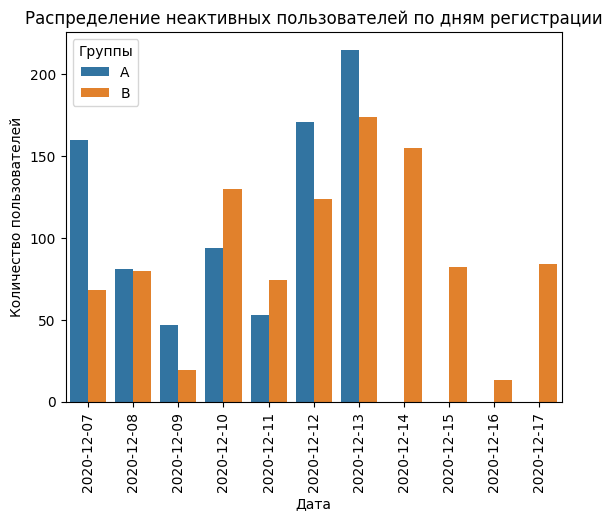

In [51]:
# построение графика распределения неактивных пользователей по дням регистрации на группы
pt = not_active.groupby(['first_date', 'group'], as_index=False)['user_id'].count()
sns.barplot(data = pt, x = 'first_date', y = 'user_id', hue = 'group')
plt.title('Распределение неактивных пользователей по дням регистрации')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.legend(title='Группы')
plt.show;

In [52]:
# распределение неактивных пользователей по регионам
pt = not_active.groupby('region', as_index = False)['user_id'].count()
pt['ratio'] = round(pt['user_id']/pt_region['user_id']*100,2)
pt

,region,user_id,ratio
0,APAC,22,44.90
1,CIS,20,47.62
2,EU,1694,51.57
3,N.America,88,56.41


Неактивных участников почти 52%. Все они являются новыми пользователями, которые были зарегистрированы с начала тестирования. Эти пользователи примерно равномерно распределены по всем регионам, чуть больше неактивных пользователей в процентном соотношении в Северной Америке.

Проанализируем действия активных пользователей.

In [53]:
# среденее количество событий на пользователя по группам
print('Среднее количество событий на всех пользователя из группы А:', round(ab_test[ab_test['group']=='A']['event_name'].count()/merge_users[merge_users['group']=='A']['user_id'].nunique()))
print('Среднее количество событий на всех пользователя из группы B:', round(ab_test[ab_test['group']=='B']['event_name'].count()/merge_users[merge_users['group']=='B']['user_id'].nunique()))

Среднее количество событий на всех пользователя из группы А: 4
Среднее количество событий на всех пользователя из группы B: 2


In [54]:
temp = ab_test.pivot_table(index = 'event_date', values = 'event_name', aggfunc = {'count'}).reset_index()

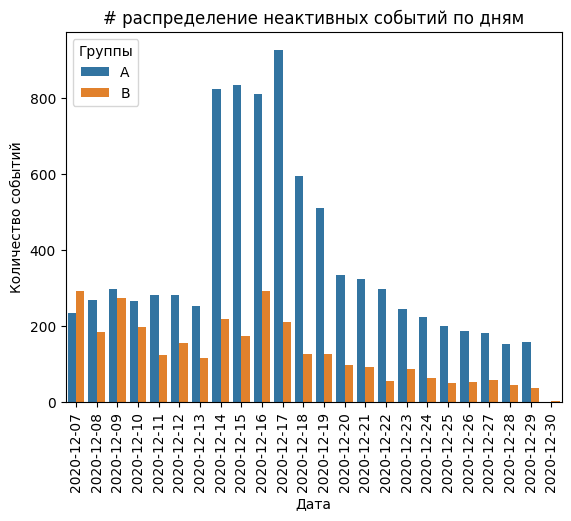

In [55]:
# построение графика распределения событий по дням с деленией на группы
pt = ab_test.groupby(['event_date', 'group'], as_index=False)['event_name'].count()
sns.barplot(data = pt, x = 'event_date', y = 'event_name', hue = 'group')
plt.title('# распределение неактивных событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=90)
plt.legend(title='Группы')
plt.show;

<b>Вывод: </b>

- за тестирование было совершено 11778 события, из них 45% - вход в систему; 
- 1708 активных пользователей из 3532 пользователей, которые стали участниками тестирования;
- активных участников из группы А почти в 2 раза больше, чем из группы В;
- неактивных участников из группы В больше, чем из группы А;
- неактивных участников почти 52% и все являются новыми пользователями;
- средние количества событий на всех пользователей (активных и неактивных) сильно различаются;
- в начале тетирования количество событий в день между группами отличались не сильно, однако после 14.12.2020 пользователи группы А совершали намного больше событий;
- маркетинговая камнания Christmas&New Year Promo не повлияла на количество событий.

### Воронка продаж

In [56]:
# названия событий и их количество
ab_test['event_name'].unique()

array(['purchase', 'product_cart', 'login', 'product_page'], dtype=object)

In [57]:
# для упрощения сортировки добавим № шага к названию событий
ab_test.loc[ab_test['event_name']=='login', 'event_name']='0_login'
ab_test.loc[ab_test['event_name']=='product_page', 'event_name']='1_product_page'
ab_test.loc[ab_test['event_name']=='product_cart', 'event_name']='2_product_cart'
ab_test.loc[ab_test['event_name']=='purchase','event_name']='3_purchase'

ab_test['event_name'].unique()

array(['3_purchase', '2_product_cart', '0_login', '1_product_page'],
      dtype=object)

В воронку событий входят следующие события:

- login - вход в систему;
- product_page - просмотр карточки товара;
- product_cart - просмотр корзины;
- purchase - покупка.

Оценим воронку продаж по уникальным пользователям.

In [58]:
# количество пользователей в воронке событий 
pt = (ab_test.pivot_table(index= 'event_name', 
                         columns = 'group', 
                         values = 'user_id', 
                         aggfunc = 'nunique')
      .reset_index())
pt

group,event_name,A,B
0,0_login,1197,511
1,1_product_page,779,286
2,2_product_cart,371,147
3,3_purchase,358,138


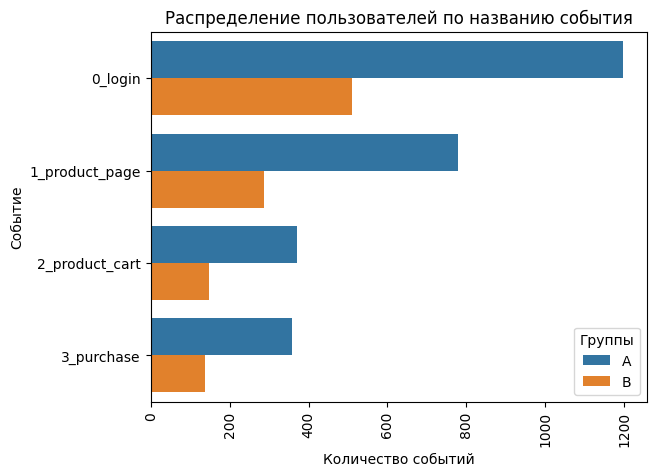

In [59]:
# график количество пользователей по названию события
pt = ab_test.groupby(['event_name', 'group'], as_index=False)['user_id'].nunique().sort_values(by = 'event_name')
sns.barplot(data = pt, y = 'event_name', x = 'user_id', hue = 'group')
plt.title('Распределение пользователей по названию события')
plt.ylabel('Событие')
plt.xlabel('Количество событий')
plt.xticks(rotation=90)
plt.legend(title='Группы')
plt.show;

Как видно из графиков, почти 100% пользователей из корзины переходять к заказу. Возможно в системе есть возможность покупки без перехода в корзину, поэтому настолько высокая конверсия последнего шага. Расчитаем конверсию шагов для каждой группы.

In [60]:
# расчет конверсии шага от предыдущего
pt = (ab_test.pivot_table(index= 'event_name', 
                         columns = 'group', 
                         values = 'user_id', 
                         aggfunc = 'nunique')
      .reset_index())
pt['CR_per_step_A'] = round(pt['A']/pt['A'].shift(1)*100,2)
pt.loc[0, 'CR_per_step_A'] = 100

pt['CR_per_step_B'] = round(pt['B']/pt['B'].shift(1)*100,2)
pt.loc[0, 'CR_per_step_B'] = 100



pt[['event_name', 'A', 'CR_per_step_A', 'B','CR_per_step_B']]

group,event_name,A,CR_per_step_A,B,CR_per_step_B
0,0_login,1197,100.00,511,100.00
1,1_product_page,779,65.08,286,55.97
2,2_product_cart,371,47.63,147,51.40
3,3_purchase,358,96.50,138,93.88


Рассчитаем конверсию от начального числа активных пользователей. 

In [61]:
# расчет конверсии от начального количества активных прльзователей
pt = (ab_test.pivot_table(index= 'event_name', 
                         columns = 'group', 
                         values = 'user_id', 
                         aggfunc = 'nunique')
      .reset_index())
pt['CR_A'] = round(pt['A']/ab_test[ab_test['group']=='A']['user_id'].nunique()*100,2)

pt['CR_B'] = round(pt['B']/ab_test[ab_test['group']=='B']['user_id'].nunique()*100,2)

pt['ratio'] = round((pt['CR_B']/pt['CR_A']-1)*100,2)

pt[['event_name', 'A', 'CR_A', 'B','CR_B', 'ratio']]



group,event_name,A,CR_A,B,CR_B,ratio
0,0_login,1197,100.00,511,100.00,0.00
1,1_product_page,779,65.08,286,55.97,-14.00
2,2_product_cart,371,30.99,147,28.77,-7.16
3,3_purchase,358,29.91,138,27.01,-9.70


<b>Вывод: </b>

Пользователей и событий в группе А сильно больше пользователей и событий в группе В, что хорошо видно на графиках воронки продаж.

95% пользователей из корзины переходят к покупке, возможно в системе есть возможность быстрой покупки без перехода в корзину, поэтому конверсия покупки столь высокая.

По сводной таблице конверсия группы В <b>ниже</b> конверсии группы А:
- просмотр карточки товара на 14%;
- просмотр корзины на 7.16%;
- покупка на 9.7%.

Таким образом ожидаемого прироста в 10% нет.

## Оценка результатов A/B-тестирования

In [62]:
# удалим этап входа в систему
ab_test_filtered = ab_test.query('event_name != "0_login"')
#список этапов
funnel = list(ab_test_filtered['event_name'].unique())
funnel.sort()

In [63]:
# сводная таблица с количеством активных пользователей всего и по этапам
funnel_table = ab_test.pivot_table(index = 'group', values = 'user_id', aggfunc = {'nunique'}).reset_index().rename(columns={'nunique':'total'})

for e in funnel:
    temp = (ab_test.query('event_name == @e')
            .pivot_table(index = 'group',
                         values = 'user_id', 
                         aggfunc = {'nunique'})
            .reset_index()
            .rename(columns={'nunique':e}))
    funnel_table = funnel_table.merge(temp, on = 'group', how = 'left')
    
funnel_table

,group,total,1_product_page,2_product_cart,3_purchase
0,A,1197,779,371,358
1,B,511,286,147,138


Оценим результаты тестирования между группами. Для этого определим является ли статистически значима разница между долями на каждом этапе.

Поскольку при А/В-тестирование будет произведено 3 сравнения (по количеству этапов) используем метод Шидака для корректировки значение требуемого уровня значимости (0.05), чтобы снизить вероятность ложнопозитивного результата (ошибки первого рода).

In [64]:
alpha = 1-(1-0.05)**(1/3)
alpha

0.016952427508441503

In [65]:
for step in funnel:
    #количество пользователей, совершивших действие шага
    count = np.array([funnel_table[funnel_table['group']=='A'][step], 
                      funnel_table[funnel_table['group']=='B'][step]])
    #количество активных пользователей
    nobs = np.array([funnel_table[funnel_table['group']=='A']['total'], 
                      funnel_table[funnel_table['group']=='B']['total']])
    
    results = proportions_ztest(count, nobs)
    
    print(f"H0: доли пользователей, совершивших действие на шаге {step}, в группах А и В равны")
    print(f"H1: доли пользователей, совершивших действие на шаге {step}, в группах А и В не равны")
    
    print('p-значение: ', results[1])

    if results[1] < alpha:
        print(f"Отвергаем нулевую гипотезу: между долями на шаге {step} есть значимая разница")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли на шаге {step} разными") 
    print()


H0: доли пользователей, совершивших действие на шаге 1_product_page, в группах А и В равны
H1: доли пользователей, совершивших действие на шаге 1_product_page, в группах А и В не равны
p-значение:  [0.00037292]
Отвергаем нулевую гипотезу: между долями на шаге 1_product_page есть значимая разница

H0: доли пользователей, совершивших действие на шаге 2_product_cart, в группах А и В равны
H1: доли пользователей, совершивших действие на шаге 2_product_cart, в группах А и В не равны
p-значение:  [0.35923161]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли на шаге 2_product_cart разными

H0: доли пользователей, совершивших действие на шаге 3_purchase, в группах А и В равны
H1: доли пользователей, совершивших действие на шаге 3_purchase, в группах А и В не равны
p-значение:  [0.22632574]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли на шаге 3_purchase разными



<b>Вывод: </b>

При проверке гипотез была отвергнула только гипотеза о равенстве долей пользователей, совершивших действие, в группах А и В только на шаге просмотра товара. Остальные не были отвергнуты, а значит нет оснований полагать, что есть различия между долями на шагах корзины и покупки в группа А и В.

## Вывод

При анализе данных было обнаружено несоответствия ТЗ.

- после фильтрации пользователей, которые приняли участие в другом тесте или попали в оба теста, участиников А/В-тестирорвания стало меньше, чем требуется по ТЗ (3532 вместо 6000);
- дата остановки тестирования не соответствует ТЗ (2020.12.30 вместо 2020-01-04);
- было отобрано 10% новых пользователей из региона EU, что не соответствует необходимому уровню в 15% по ТЗ.

Дальнейшее исследование данных показало, что:
- в период тестирования была проведена маркетинговая кампания, которая могла исказить результаты;
- группы распределены не равномерно (2018 в А и 1514 в В)
- в качестве испытуемых были неактивные пользователи, количество которых примерно такое же как и активных;
- распределение активных и неактивных пользователей также не равномерно, в итоге количество реальных пользователей в группе А в 2 раза больше, чем в группе В.

Проверка гипотез показала, что есть разница между долями пользователей, совершивших событие, в группе А и В только на шаге просмотра товара, на остальных шагах значимой разницы нет.

А/В-тестирование было проведено некорректно, резальтатам проверки гипотез доверять нельзя. Необходимо провести новое тестирование в соответствии ТЗ и равномерных распределением групп. Необходимо учитывать график маркетинговых компаний, которые также могут исказить результаты. Кроме того для объективности стоит выбрать период тестирования без праздников.